In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math
import datetime
import re

%load_ext autoreload
%autoreload 2

import warnings; warnings.simplefilter('ignore')
import os, codecs, string, random
from numpy.random import seed as random_seed
from numpy.random import shuffle as random_shuffle

seed = 42
random.seed(seed)
np.random.seed(seed)

#NLP libraries
import spacy, nltk, gensim, sklearn
import pyLDAvis.gensim_models
#import pyLDAvis.gensim #LDA visualization library

import gensim #the library for Topic modelling
from gensim.models.ldamulticore import LdaMulticore
from gensim import corpora, models
from nltk.corpus import stopwords
import string
from nltk.stem.wordnet import WordNetLemmatizer
from itertools import chain

import scipy
import statsmodels.stats.multitest as multiple
from scipy.interpolate import *
from scipy.interpolate import make_interp_spline

#Vader
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from collections import Counter
import operator

from empath import Empath

import networkx as nx                        # a really useful network analysis library

/home/xavier/miniconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


In [2]:
# import CMU database
data_folder = './MovieSummaries/'

summaries = pd.read_csv(data_folder+'plot_summaries.txt', sep='	', header=None, names=["wiki_id", "summary"])
movie_meta = pd.read_csv(data_folder+'movie.metadata.tsv', sep='	', header=None, names=["wiki_id", "freebase_id", "movie_name", "release_date", "revenue", "runtime", "languages", "coutries", "genres"])

In [3]:
# merging CMU datasets
df_total = summaries.merge(movie_meta, on="wiki_id", how = 'right')
df_total["languages"] = df_total.apply(lambda x: list(eval(x["languages"]).values()), axis=1)
df_total["coutries"] = df_total.apply(lambda x: list(eval(x["coutries"]).values()), axis=1)
df_total["genres"] = df_total.apply(lambda x: list(eval(x["genres"]).values()), axis=1)

In [4]:
df_relevant = df_total.copy()

In [5]:
# clean one dirty entry and convert to datetime
df_relevant.loc[df_relevant['wiki_id']== 29666067, 'release_date'] = datetime.datetime(2010, 12, 2)
dates = pd.to_datetime(df_relevant['release_date'])
df_relevant['release_date'] = dates

# since we are investigating movies over time, we only consider movies with a release date
df_relevant = df_relevant[df_relevant['release_date'].notna()]  

In [6]:
# df_summaries holds all movies with a summary for topic and sentiment analysis
df_summaries = df_relevant.copy()
df_summaries = df_summaries.sort_values(by=['release_date'])
df_summaries = df_summaries.dropna(subset=['summary'])
df_summaries.head()

,wiki_id,summary,freebase_id,movie_name,release_date,revenue,runtime,languages,coutries,genres
25563,73372,The scene is all filmed from a stationary came...,/m/0jq3g,Blacksmith Scene,1893-01-01,NaN,0.566667,[Silent film],[United States of America],"[Short Film, Silent film, Indie, Black-and-white]"
67253,10109752,After finding out that her father is suffering...,/m/02q23xk,Miss Jerry,1894-10-09,NaN,NaN,[Silent film],[United States of America],"[Short Film, Silent film, Indie, Black-and-white]"
81230,10104497,James J. Corbett and Peter Courtney both take ...,/m/02q1zd3,Corbett and Courtney Before the Kinetograph,1894-11-17,NaN,NaN,[Silent film],[United States of America],"[Short Film, Silent film, Indie, Black-and-white]"
67567,10330688,The film consists of a series of animations on...,/m/02q8pr6,Autour d'une cabine,1895-01-01,NaN,15.000000,[Silent film],[France],"[Short Film, Silent film, Animation, Comedy, I..."
73179,10483292,Two men stand working as blacksmiths. The one ...,/m/02qfh7r,Les Forgerons,1895-01-01,NaN,0.816667,[Silent film],[France],"[Short Film, Silent film, Indie, Black-and-whi..."


In [7]:
print(len(df_total))
print(len(df_relevant))
print(len(df_summaries))

81741
74839
39586


Here, we have three databases of different lengths :
- df_total of length 81741, which contains all movies from the CMU movie database, obtained from merging the metadata dataset with the summaries dataset
- df_relevant of length 74839, which contains all movies that have a marked release date
- df_summaries of length 39586, which contains all movies that have a marked release date and a summary

## Creation of a dataset with plot summmaries 

Since we only have around 40 000 films that include a summary, we tried to expand that by scraping Wikipedia using this tool : https://github.com/piki/wikipedia-film-database. The result of our scrape is saved in "with_plot.txt".

In [8]:
# import dataset scraped from wikipedia
df_wikipedia = pd.read_json('with_plot.txt', lines=True)
df_wikipedia = df_wikipedia[['id', 'directors', 'plot']]
df_wikipedia.rename(columns={'id':'wiki_id', 'plot':'summary'}, inplace=True)

# only keep rows that have a plot summary
df_wikipedia = df_wikipedia[df_wikipedia['summary'].notna()] 

In [9]:
# The scraped articles have some HTML left, so we use regex to remove those
def remove_html(line):
    CLEANR = re.compile('<!--.*--') 
    CLEANR2 = re.compile('<ref.*</ref')  
    CLEANR3 = re.compile('<Ref.*</ref')
    CLEANR4 = re.compile('<ref.*/>')
    x = re.sub(CLEANR, '', line)
    x = re.sub(CLEANR3, '', x)
    x = re.sub(CLEANR2, '', x)
    x = re.sub(CLEANR4, '', x)
    x = x.replace('\n', '') # remove newlines
    # remove unnecessary punctuation
    x = x.replace('([[', '') 
    x = x.replace(']])', '') 
    x = x.replace('[[', '') 
    x = x.replace(']]', '')
    x = x.replace('|', ' | ')
    x = x.replace('**', '"') 
    x = x.replace('*', "'") 
    # remove articles that are too short to be relevant
    if(len(line) < 50):
        x = ""      
    return x

# remove html references in plot summaries
df_wikipedia['summary'] = df_wikipedia['summary'].apply(lambda x : remove_html(x))

In [10]:
# Method that takes the wikipedia summary if the CMU database doesn't provide one
def pick_better_plot(x):
    if x.summary_x == '':
        if x['summary_y'] == '':
            return np.nan
        else:
            return x['summary_y']
    else:
        return x['summary_x']

    
summary_df = pd.merge(df_relevant,df_wikipedia,on='wiki_id',how='left')
summary_df['summary_x'] = summary_df['summary_x'].fillna('')
summary_df['summary_y'] = summary_df['summary_y'].fillna('')


# create new column with the wikipedia summary if CMU doesn't provide one
summary_df['summary'] = summary_df.apply(lambda x : pick_better_plot(x),axis=1)

# keep only rows that have a summary
summary_df = summary_df[summary_df['summary'].notna()]
summary_df = summary_df.drop(columns=['summary_x', 'summary_y'])

In [11]:
print(len(summary_df))
print(len(summary_df)/len(df_summaries))
print(len(df_summaries)/len(df_relevant))
print(len(summary_df)/len(df_relevant))

51568
1.3026827666346688
0.5289488101123746
0.6890524993653042


We now have 51568 movies with a summary. This represents an increase of 130% from what we had before, and almost 70% of movies in the CMU dataset that have a release date now have a summary, compared to 53% before.

# Defining the functions

## Definition of helper functions 

Below, we define a set of helper functions that we will use throughout the notebook to calculate distributions, generate plots, get subsets of the dataset etc.

In [12]:
# get all movies in df made in country
def get_country_movies(df, country):
    return df[df.coutries.apply(lambda x : country in x)]

# get all movies in df made in countries other than country
def get_other_country_movies(df, country):
    return df[df.coutries.apply(lambda x : country not in x)]

In [13]:
# get all movies in df made after begin and before end
def create_history_span(df, begin, end):
    return df.loc[(df.release_date.dt.year < end) & (df.release_date.dt.year > begin)]

# get all movies in df made before begin and after end
def create_inverse_history_span(df, begin, end):
    return df.loc[(df.release_date.dt.year >= end) | (df.release_date.dt.year <= begin)]

In [14]:
# get all movies in df made in year
def get_one_year(df, year):
    return df.loc[(df.release_date.dt.year == year)]

In [15]:
# get the proportion represented by number_of_films by year (where number_of_films is a count of some films per year in df)
def create_proportion_by_year(df, number_of_films):
    tot_by_year = df.groupby(df.release_date.dt.year)['wiki_id'].count()
    number_of_films_by_year = number_of_films.groupby(number_of_films.release_date.dt.year)['wiki_id'].count()
    number_of_films_by_year = number_of_films_by_year/tot_by_year
    return number_of_films_by_year.apply(lambda x: 0 if np.isnan(x) else x)

In [16]:
# plot proportion in a bar plot with title "title"
def plot_proportion(proportion,title):
    proportion.plot.bar(rot=45, figsize=(10, 6))
    plt.locator_params(nbins=20)
    plt.ylabel("proportion")
    plt.title(title)
    return proportion

In [17]:
# get the proportion of movies of genre "genre" by year in df
def proportion_of_movie_genre(df, genre):
    war_movies_genre = df[df.genres.apply(lambda x :genre in x)]
    proportion_genre = create_proportion_by_year(df, war_movies_genre)
    return proportion_genre

In [18]:
# get the proportion of movies with any word in "l" in their summary
def proportion_of_list_in_summary(df, l):
    pd.options.mode.chained_assignment = None
    movies = df[df.summary.apply(lambda x : True if any(ext in x.lower() for ext in l) else False)]
    movies_by_year = create_proportion_by_year(df,movies)
    return movies_by_year

In [19]:
def comparing_three_plots(title1, title2, title3, ylabel, xlabel, df1, df2, df3):
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True,figsize=(25, 5))
    ax1.bar(df1.index, df1.values, width=0.5)
    ax1.set_title(title1)
    ax1.set_ylabel(ylabel)
    ax1.set_xlabel(xlabel)
    ax2.set_xlabel(xlabel)
    ax2.set_title(title2)
    ax2.bar(df2.index, df2.values, width=0.5)
    ax3.set_xlabel(xlabel)
    ax3.set_title(title3)
    ax3.bar(df3.index, df3.values, width=0.5)

In [20]:
def comparing_two_plots(title1, title2, ylabel, xlabel, df1, df2):
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(20, 5))
    ax1.bar(df1.index, df1.values, width=0.5)
    ax1.set_title(title1)
    ax1.set_ylabel(ylabel)
    ax1.set_xlabel(xlabel)
    ax2.set_xlabel(xlabel)
    ax2.set_title(title2)
    ax2.bar(df2.index, df2.values, width=0.5)

## Sentiment analysis

Below, we define the functions we will use to compute and plot the sentiment analysis.

In [21]:
analyzer = SentimentIntensityAnalyzer()

In [22]:
# compute the the positive, negative, neutral and compound sentiment analysis of the movie summaries
# add them to df for each movie
def sentiment_df(df):
    df_copy = df.copy()
    
    # calculate the sentiment over the summaries
    df_copy['sentiment'] = df_copy['summary'].apply(lambda x: analyzer.polarity_scores(x))

    # isolate the most interesting values
    df_copy['positive'] = df_copy['sentiment'].apply(lambda x: x['pos'])
    df_copy['neutral'] = df_copy['sentiment'].apply(lambda x: x['neu'])
    df_copy['negative'] = df_copy['sentiment'].apply(lambda x: x['neg'])
    df_copy['compound'] = df_copy['sentiment'].apply(lambda x: x['compound'])
    
    return df_copy

In [23]:
# plot the "attribute" attribute of the sentiment analysis of "span"
def plot_sentiment_country_span(span, attribute, year:bool):
    fig, axs = plt.subplots(figsize=(25, 5))
    if year:
        sentiments = span.groupby(span.release_date.dt.year)[attribute].mean()
    else:
        sentiments = span.groupby(span.release_date)[attribute].mean()
    sentiments.plot(kind='bar', rot=90, ax=axs)

## Most common words and topic analysis

Below, we define the functions we will use to compute the most common words in a text, and to compute and plot topic analysis

In [24]:
# the texts are in english
nlp = spacy.load('en_core_web_sm')
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS

In [25]:
# from tutorial 10
def get_chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]

In [26]:
# count nuber of lemmatized words in text
def count_words(text):
    summary = nlp(text)
    # lemmatize and remove stopwords and punctuation
    tokens = [token.lemma_ for token in summary if token.is_stop != True and token.is_punct != True]
    tokens_lower = [x.lower() for x in tokens]
    return Counter(tokens_lower)

In [27]:
# get n most common words in summaries of dataframe df
def most_common_sum(df, n):
    text = ' '.join(df["summary"])
    if(len(text) < 1000000):
        return count_words(text).most_common(n)
    # if text is too long to compute directly, compute in chunks
    else:
        chunks = [x for x in get_chunks(text,1000000)]
        master_list = []
        # get word count by chunk
        for chunk in chunks:
            counter = count_words(chunk).items()
            [master_list.append(x) for x in counter]
        # merge into master list
        d = {x: 0 for x, _ in master_list}
        for word, num in master_list:
            d[word] += num
        out = list(map(tuple, d.items()))
        # sort by word count and return n most common words
        sorted_list = sorted(out,key=lambda t: t[1],reverse=True)
        return sorted_list[0:n]

In [28]:
# use Empath library to get topic analysis for categories "cats" across all summaries in df
def topic_analysis(df, cats):
    text = ' '.join(df["summary"])
    lexicon = Empath()
    if(len(text) < 1000000):
        doc = nlp(text)
        return lexicon.analyze(doc.text,categories = cats, normalize=True)
     # if text is too long to compute directly, compute in chunks
    else:
        chunks = [x for x in get_chunks(text,1000000)]
        categories_sum =  dict(zip(cats, [0] * len(cats)))
        for chunk in chunks:
            doc = nlp(chunk)
            topics = lexicon.analyze(doc.text,categories = cats, normalize=True)
            for key, value in topics.items():
                categories_sum[key] += value
        # compute average for each category across all chunks    
        for key, value in categories_sum.items():
            categories_sum[key] /= len(chunks)
        return categories_sum

In [29]:
# compute topic analysis for categories "cats" across all summaries in df in each year from "begin" to "end"
def topic_analysis_by_year(df, begin, end, cats):
    categories_all =  dict(zip(cats, [ [] for _ in range(len(cats)) ]))
    # for every year
    for year in range(begin, end):
        # get topic analysis all movies made in that year
        df_year = get_one_year(df, year)
        categories_year = topic_analysis(df_year, cats)
        # append yearly topic analysis for every category
        if categories_year is not None :
            for key, value in categories_year.items():
                old = categories_all[key]
                old.append(value)
                categories_all[key] = old
        # if there are no movies in that year, append 0
        else:
            for key, value in categories_all.items():
                old = categories_all[key]
                old.append(0)
                categories_all[key] = old
    return categories_all

In [30]:
# plot yearly topic analysis in a 2x2 subplot
def plot_topic_analysis_by_year(df, begin, end, cats, name, country):
    fig, axs = plt.subplots(2, 2, figsize=(10,6))
    values = topic_analysis_by_year(df, begin, end, cats)
    
    MAXIMUM_RANGE = 0.055
        
    x_axis = range(begin, end)
    colors = ["orange", "green", "blue", "black"]
    i = 0
    for j in range(2):
        for k in range(2):
            axs[j][k].plot(x_axis, values[cats[i]], label = cats[i], color=colors[i])
            axs[j][k].title.set_text(cats[i])
            axs[j][k].set_xlabel("Film release date")
            axs[j][k].set_ylabel("Frequency of the topic")
            i = i+1
            axs[j][k].set_ylim(0, MAXIMUM_RANGE)
    plt.tight_layout()
    fig.suptitle(country)
    plt.savefig(name)
    plt.show()

## Clustering and LDA

Here we define functions used to see if we can find clusters and communities in the movies, and functions used for LDA.

In [31]:
def draw_graph3(networkx_graph,notebook=True,output_filename='graph.html',show_buttons=True,only_physics_buttons=False):
    """
    This function accepts a networkx graph object,
    converts it to a pyvis network object preserving its node and edge attributes,
    and both returns and saves a dynamic network visualization.
    
    Valid node attributes include:
        "size", "value", "title", "x", "y", "label", "color".
        
        (For more info: https://pyvis.readthedocs.io/en/latest/documentation.html#pyvis.network.Network.add_node)
        
    Valid edge attributes include:
        "arrowStrikethrough", "hidden", "physics", "title", "value", "width"
        
        (For more info: https://pyvis.readthedocs.io/en/latest/documentation.html#pyvis.network.Network.add_edge)
        
    
    Args:
        networkx_graph: The graph to convert and display
        notebook: Display in Jupyter?
        output_filename: Where to save the converted network
        show_buttons: Show buttons in saved version of network?
        only_physics_buttons: Show only buttons controlling physics of network?
    """
    
    # import
    from pyvis import network as net
    
    # make a pyvis network
    pyvis_graph = net.Network(notebook=notebook)
    
    # for each node and its attributes in the networkx graph
    for node,node_attrs in networkx_graph.nodes(data=True):
        pyvis_graph.add_node(str(node),**node_attrs)
        
    # for each edge and its attributes in the networkx graph
    for source,target,edge_attrs in networkx_graph.edges(data=True):
        # if value/width not specified directly, and weight is specified, set 'value' to 'weight'
        if not 'value' in edge_attrs and not 'width' in edge_attrs and 'weight' in edge_attrs:
            # place at key 'value' the weight of the edge
            edge_attrs['value']=edge_attrs['weight']
        # add the edge
        pyvis_graph.add_edge(str(source),str(target),**edge_attrs)
        
    # turn buttons on
    if show_buttons:
        if only_physics_buttons:
            pyvis_graph.show_buttons(filter_=['physics'])
        else:
            pyvis_graph.show_buttons()
    
    # return and also save
    return pyvis_graph.show(output_filename)


In [32]:
from networkx.algorithms import community

def community_detection(movies, min_wt = 0.97, draw_interactive_graph=False):
    tokens = []
    lemma = []
    pos = []
    parsed_doc = [] 
    col_to_parse = 'summary'

    print(movies.shape)
    for doc in nlp.pipe(movies[col_to_parse].astype('unicode').values, batch_size=50,
                            n_process=3):
        if doc.is_parsed:
            parsed_doc.append(doc)
            tokens.append([n.text for n in doc])
            lemma.append([n.lemma_ for n in doc])
            pos.append([n.pos_ for n in doc])
        else:
            # We want to make sure that the lists of parsed results have the
            # same number of entries of the original Dataframe, so add some blanks in case the parse fails
            tokens.append(None)
            lemma.append(None)
            pos.append(None)
    movies['parsed_doc'] = parsed_doc
    movies['comment_tokens'] = tokens
    movies['comment_lemma'] = lemma
    movies['pos_pos'] = pos
    world_data = movies.dropna(subset=['summary'])
    world_data[world_data.summary != '']
    raw_G = nx.Graph() # undirected
    x = world_data['wiki_id']
    y = world_data['parsed_doc']
    z = list(zip(x,y))

    # Use a list comprehension to add the edges to the graph
    edges = [(a, b, i.similarity(j)) for (a,i) in z for (b,j) in z if a != b and not raw_G.has_edge(j, i)]

    # Use the add_weighted_edges_from method to add the edges to the graph
    raw_G.add_weighted_edges_from(edges)

    print(raw_G.number_of_nodes(), "nodes, and", raw_G.number_of_edges(), "edges created.")
    
    edges_to_kill = []
    for n, nbrs in raw_G.adj.items():
        #print("\nProcessing origin-node:", n, "... ")
        for nbr, eattr in nbrs.items():
            # remove edges below a certain weight
            data = eattr['weight']
            if data < min_wt: 
                # print('(%.3f)' % (data))  
                # print('(%d, %d, %.3f)' % (n, nbr, data))  
                #print("\nNode: ", n, "\n <-", data, "-> ", "\nNeighbour: ", nbr)
                edges_to_kill.append((n, nbr)) 
                
    for u, v in edges_to_kill:
        if raw_G.has_edge(u, v):   # catches (e.g.) those edges where we've removed them using reverse ... (v, u)
            raw_G.remove_edge(u, v)
    strong_G = raw_G
    strong_G.remove_nodes_from(list(nx.isolates(strong_G)))
    
        
    communities = community.louvain_communities(strong_G)
    #next_level_communities = next(communities_generator)
    return (strong_G, communities)

In [33]:
lemma = WordNetLemmatizer()
stopwords_set = set(stopwords.words('english'))
punctuation_set = set(string.punctuation)
names_set = {'lucas', 'pierre', 'baptiste', 'garance', 'marius', 'jean', 'roxane', 'jeanne', 'george', 'émile', 'louis', 'louise', 'robert', 
             'mario', 'françois', 'fanny', 'liliom', 'michel', 'frédérick', 'christina', 'christian', 'christine', 'andré', 'george', 
             'edmund', 'julie', 'marie', 'jo', 'anne', 'genevieve'}


# remove stopwords and punctuation
def clean_text(text):
    no_stopwords = ' '.join([word for word in text.lower().split() if word not in stopwords_set])
    no_punctuation = ''.join(ch for ch in no_stopwords if ch not in punctuation_set)
    no_names = ' '.join([word for word in no_punctuation.split() if word not in names_set])
    return no_names

# lemmatize the text
def lemmatize(text):
    lemmatized = ' '.join([lemma.lemmatize(word) for word in text.split()])
    return lemmatized.split()

# compute the LDA for the given dataframe
def LDA(dataframe, num_topics=5):
    
    # remove stopwords and punctuation in the summaries
    dataframe['clean_summary'] = dataframe['summary'].apply(clean_text)
    
    # lemmatize the summaries
    dataframe['clean_summary'] = dataframe['clean_summary'].apply(lemmatize)
    
    # create dictionary (all unique words in all the summaries)
    dictionary = corpora.Dictionary(dataframe['clean_summary'])
    
    # create the document term matrix (frequencies and number of words : bag of words)
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in dataframe['clean_summary']]

    # init the LDA model
    lda = gensim.models.ldamodel.LdaModel
    
    # compute the LDA
    ldamodel = lda(doc_term_matrix, num_topics=num_topics, id2word=dictionary, passes=50, minimum_probability=0)
    
    # print the topics found
    print("--- Here are all the topics found : ---")
    topics = ldamodel.print_topics()
    for i in range(len(topics)):
        print(topics[i])
        print("---")
        
    lda_display = pyLDAvis.gensim_models.prepare(ldamodel, doc_term_matrix, dictionary, sort_topics=True, mds='mmds')
    
    return lda_display, doc_term_matrix, ldamodel

In [34]:
def data_frame_of_communities(communities):
    blip = []
    for com in communities:
        Ger_com =summary_df[summary_df.wiki_id.isin(com)]
        blip.append(Ger_com)
    return blip

In [35]:
def topic_detetction_country(df, country, period):
    countryDf = df[df.coutries.apply(lambda x :country in x)]
    period_countryDf = countryDf.loc[(df.release_date.dt.date <= period[1]) & (df.release_date.dt.date >= period[0])]
    (graph, communities) = community_detection(period_countryDf, draw_interactive_graph=False)
    commu = data_frame_of_communities(communities)
    commu = [x for x in commu if len(x)>2]
    displays = []
    for i, comm in enumerate(commu):
        print('cluster', str(i+1))
        display, doc_term_matrix_jap, ldamodel_jap = LDA(comm, num_topics=3)
        displays.append(display)
    return displays

# Data exploration

We first plot the proportion of War films per year.

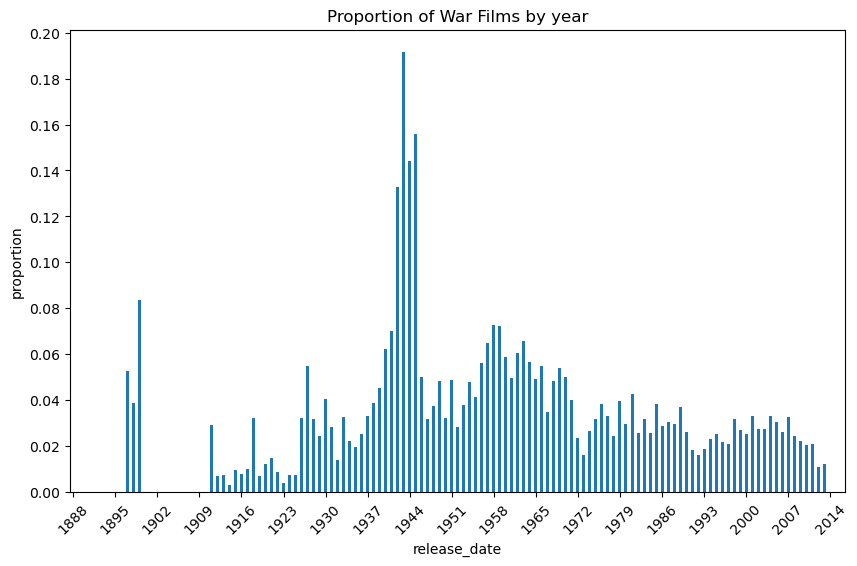

In [36]:
war_movies_by_year = plot_proportion(proportion_of_movie_genre(df_relevant, "War film"), "Proportion of War Films by year")

We can see that there is a peak of War movies during World War II.

# Case Study : World War II

Firstly we'll just look at movies made around World War 2, that is from 1930 to 1955. First, we look at the number of movies produced by each of the main participating countries.

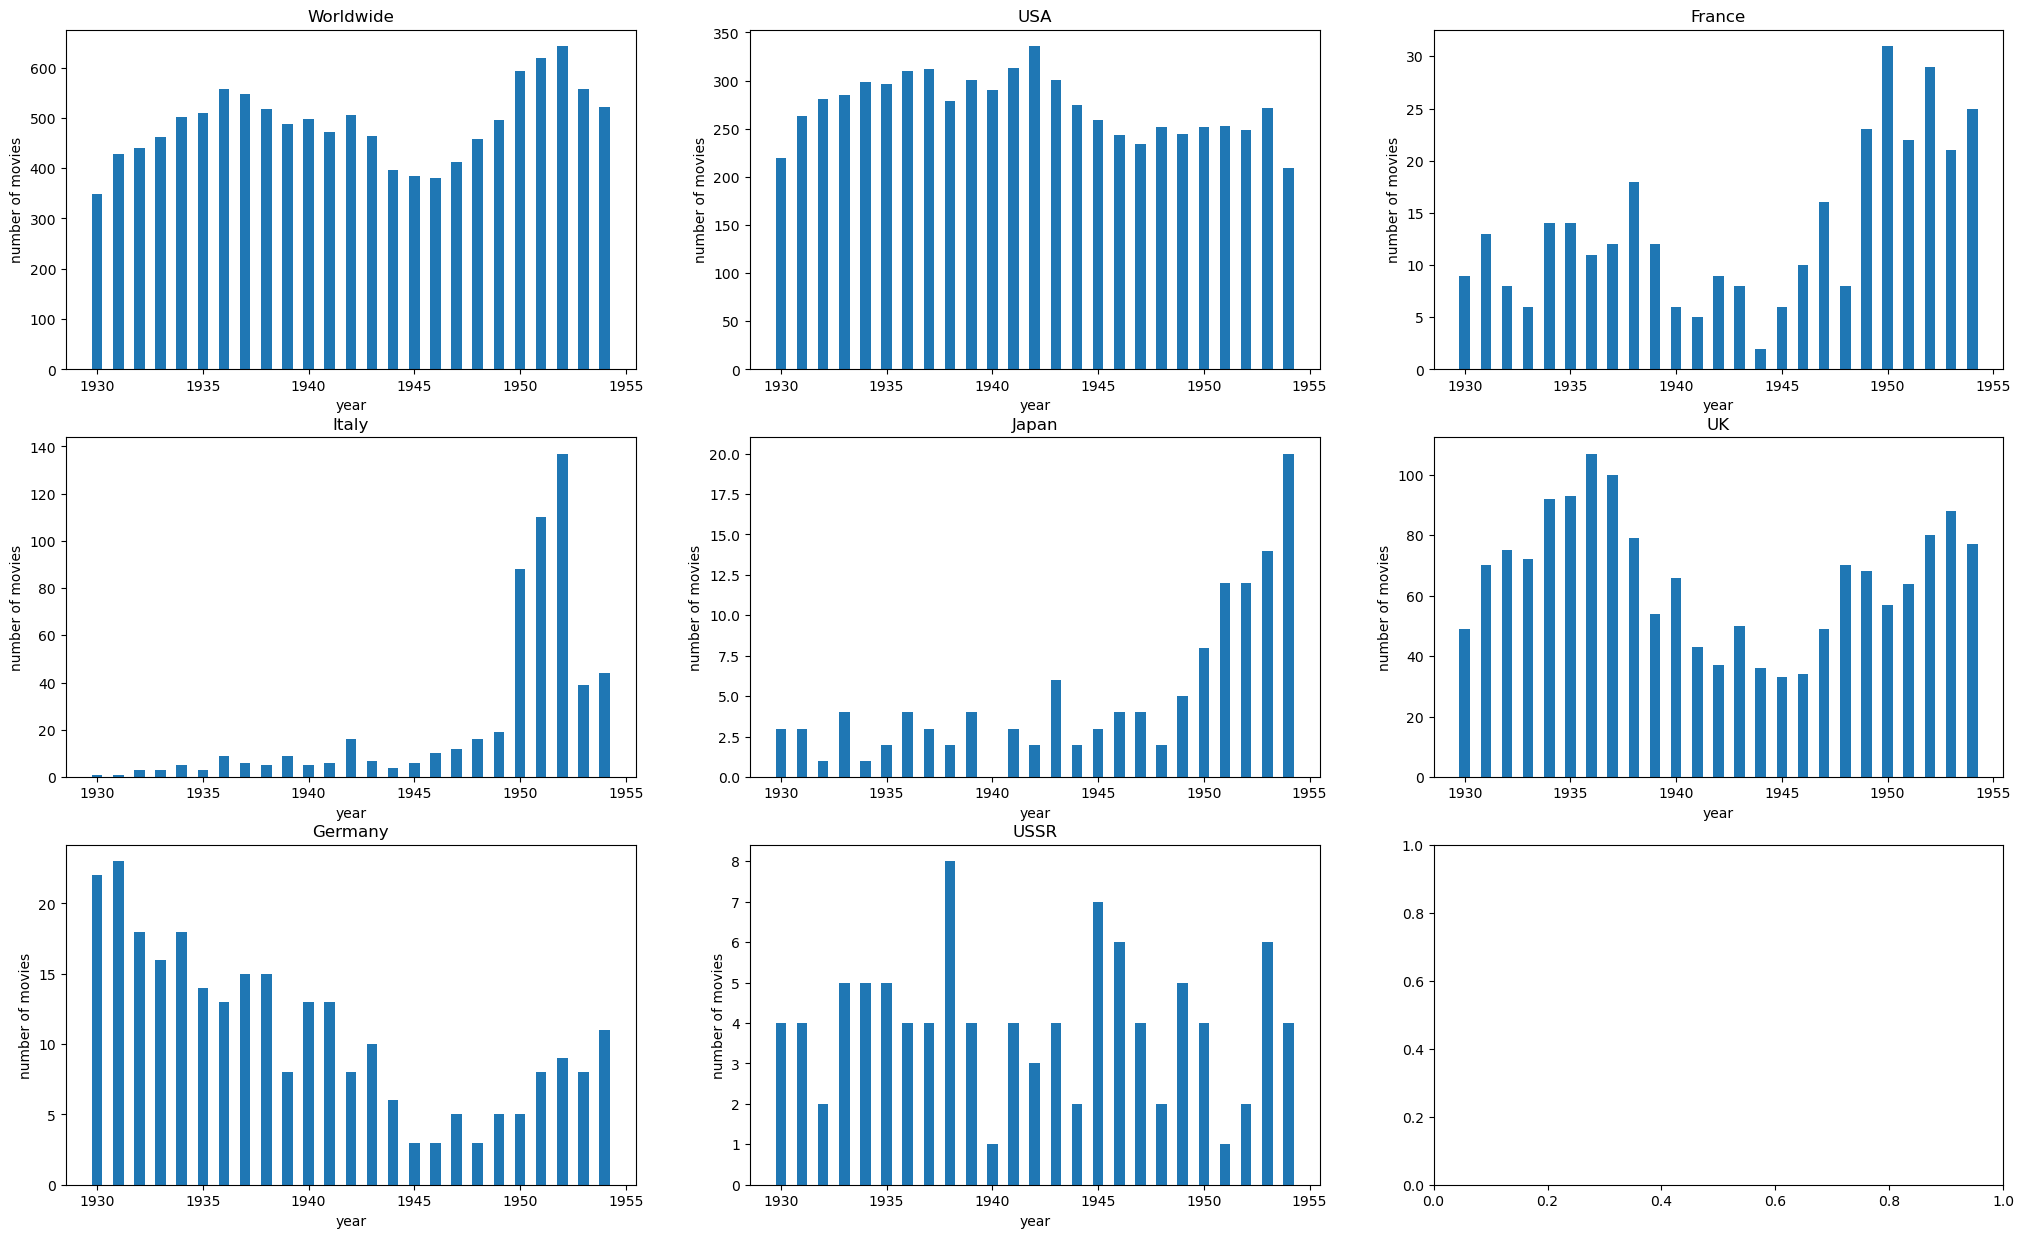

In [37]:
relevant_world_war_2 = create_history_span(df_relevant, 1929, 1955)

world_films = relevant_world_war_2.groupby(relevant_world_war_2.release_date.dt.year)['wiki_id'].count()
usa_films = get_country_movies(relevant_world_war_2, "United States of America").groupby(relevant_world_war_2.release_date.dt.year)['wiki_id'].count()
france_films = get_country_movies(relevant_world_war_2, "France").groupby(relevant_world_war_2.release_date.dt.year)['wiki_id'].count()
italy_films = get_country_movies(relevant_world_war_2, "Italy").groupby(relevant_world_war_2.release_date.dt.year)['wiki_id'].count()
japan_films = get_country_movies(relevant_world_war_2, "Japan").groupby(relevant_world_war_2.release_date.dt.year)['wiki_id'].count()
uk_films = get_country_movies(relevant_world_war_2, "United Kingdom").groupby(relevant_world_war_2.release_date.dt.year)['wiki_id'].count()
germany_films = relevant_world_war_2[relevant_world_war_2.coutries.apply(lambda x : "Germany" in x or "West Germany" in x)].groupby(relevant_world_war_2.release_date.dt.year)['wiki_id'].count()
ussr_films = relevant_world_war_2[relevant_world_war_2.coutries.apply(lambda x : "Soviet Union" in x or "Russia" in x)].groupby(relevant_world_war_2.release_date.dt.year)['wiki_id'].count()

titles = [["Worldwide", "USA", "France"], ["Italy", "Japan", "UK"], ["Germany", "USSR"]]
dfs = [[world_films, usa_films, france_films], [italy_films, japan_films, uk_films], [germany_films, ussr_films]]

f, axs = plt.subplots(3, 3,figsize=(25, 15))
for x in range(0, 3):
    max_range = 2 if x==2 else 3
    for y in range(0, max_range):
        ax = axs[x][y]
        df = dfs[x][y]
        ax.set_ylabel("number of movies")
        ax.set_xlabel("year")
        ax.set_title(titles[x][y])
        ax.bar(df.index, df.values, width=0.5)
   


From here, we only consider movies that have a summary in our dataset.

In [38]:
begin = 1930
end = 1955

In [39]:
df_ww2 = create_history_span(summary_df, begin, end)
print("There are", len(df_ww2), "movies made worldwide bewteen", begin, "and", end)

There are 8237 movies made worldwide bewteen 1930 and 1955


We will first run some of the above functions over all **german** movies during this period **(1930 to 1955)**. We will explore the most common words in the summaries, the sentiment analysis over time, and the topic analysis in categories "Love", "War", "Death" and "Family". We chose these categories because they were both well represented in movies made around this time worldwide, and because they relate (or are opposite) to the subject of war.

## Germany

In [40]:
# get all the german movies
df_ww2_germany = df_ww2[df_ww2.coutries.apply(lambda x : "Germany" in x or "West Germany" in x)]

# calculate sentiment and add it nicely to the df
df_ww2_germany = sentiment_df(df_ww2_germany)

In [41]:
print("There are", len(df_ww2_germany), "movies made in Germany bewteen", begin, "and", end)

There are 119 movies made in Germany bewteen 1930 and 1955


In [42]:
print("The 40 most common words in German movies are : ")
print(most_common_sum(df_ww2_germany, 40))

The 40 most common words in German movies are : 
[('film', 78), ('german', 63), ('find', 56), ('love', 54), ('man', 53), ('war', 50), (' ', 49), ('leave', 46), ('von', 46), ('take', 42), ('young', 41), ('father', 41), ('fall', 40), ('return', 39), ('woman', 36), ('meet', 36), ('day', 35), ('|', 34), ('die', 33), ('girl', 32), ('order', 31), ('british', 31), ('tell', 31), ('manuela', 31), ('nazi', 30), ('work', 30), ('world', 30), ('escape', 29), ('play', 29), ('plan', 28), ('end', 28), ('son', 28), ('try', 28), ('old', 28), ('follow', 27), ('hitler', 27), ('give', 27), ('night', 27), ('daughter', 27), ('friend', 26)]


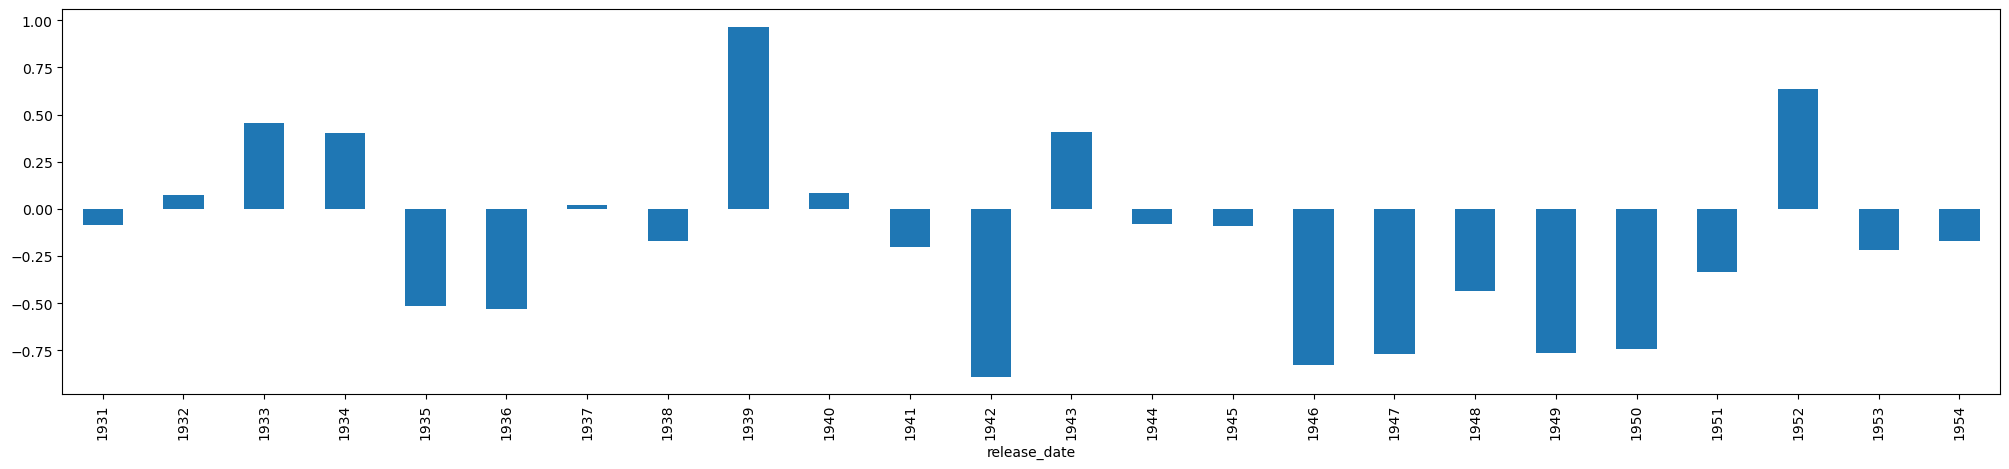

In [43]:
plot_sentiment_country_span(df_ww2_germany, 'compound', year=True)

Seeing the compound value of all the movies at this period we can clearly see that the post war (1946-1951) overall sentiment is negative.


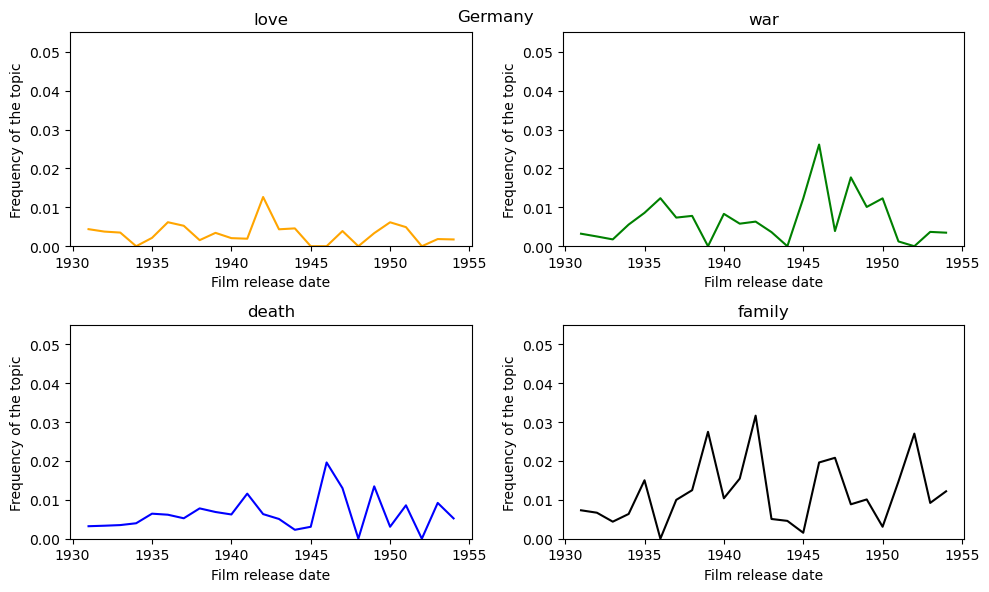

In [44]:
categories = ["love", "war", "death", "family"]
plot_topic_analysis_by_year(df_ww2_germany, begin+1, end, categories, "test", "Germany")

We can see that war and death follow more or less the same curve, which makes sense since they are extremely related topics. We can also see that family is the most recurring topic in Germany, especially during the war itself (1939-1945).

___

# France

We then run some data analysis methods over all **french** movie during this period **(1930 to 1955)**. We explore the same things as above.

In [45]:
# get all the french movies
df_ww2_french = get_country_movies(df_ww2, 'France')

# calculate sentiment and add it nicely to the df
df_ww2_french = sentiment_df(df_ww2_french)

In [46]:
print("There are", len(df_ww2_french), "movies made in France bewteen", begin, "and", end)

There are 193 movies made in France bewteen 1930 and 1955


In [47]:
print("The 40 most common words in French movies are : ")
print(most_common_sum(df_ww2_french, 40))

The 40 most common words in French movies are : 
[('find', 138), (' ', 130), ('love', 125), ('man', 109), ('leave', 96), ('tell', 91), ('take', 91), ('young', 82), ('return', 82), ('woman', 81), ('film', 81), ('life', 69), ('go', 69), ('try', 68), ('|', 67), ('away', 63), ('wife', 62), ('father', 62), ('war', 60), ('paris', 58), ('end', 57), ('night', 56), ('come', 56), ('kill', 55), ('town', 55), ('day', 55), ('friend', 55), ('old', 53), ('french', 53), ('robert', 53), ('fall', 50), ('de', 50), ('police', 49), ('see', 47), ('run', 46), ('time', 45), ('work', 45), ('decide', 45), ('jean', 44), ('arrive', 44)]


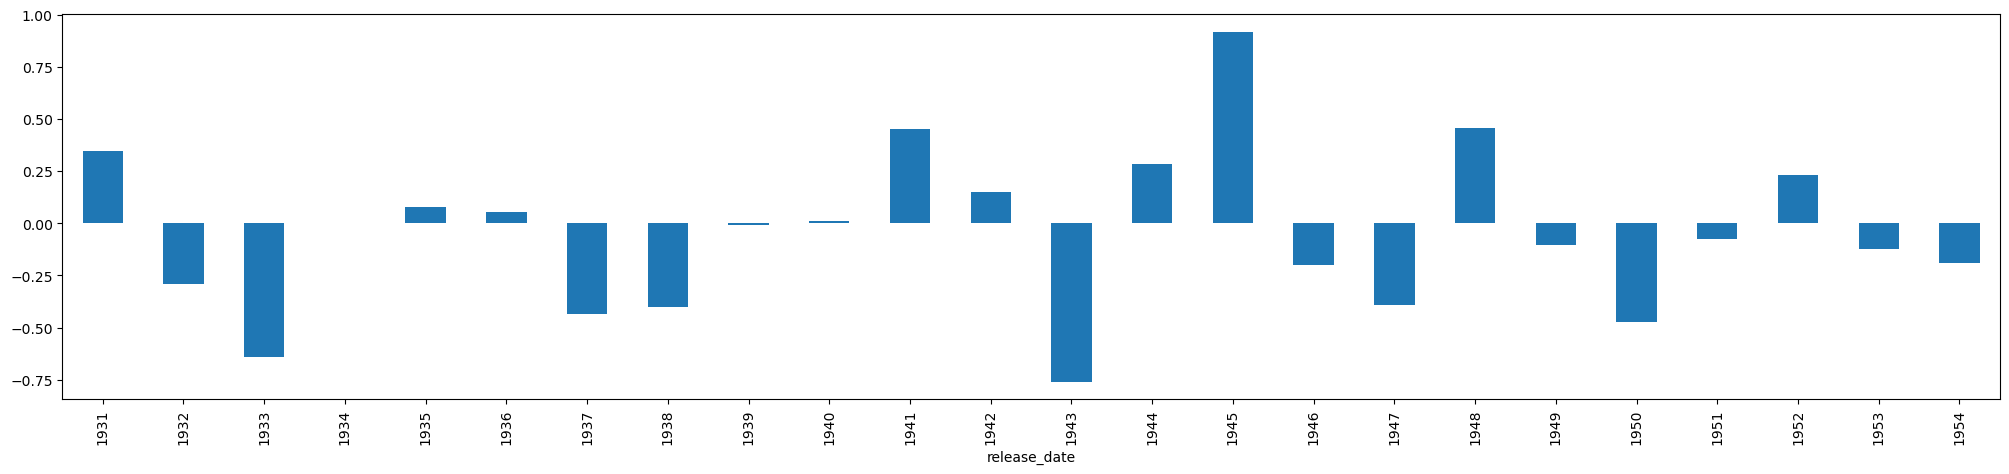

In [48]:
plot_sentiment_country_span(df_ww2_french, 'compound', year=True)

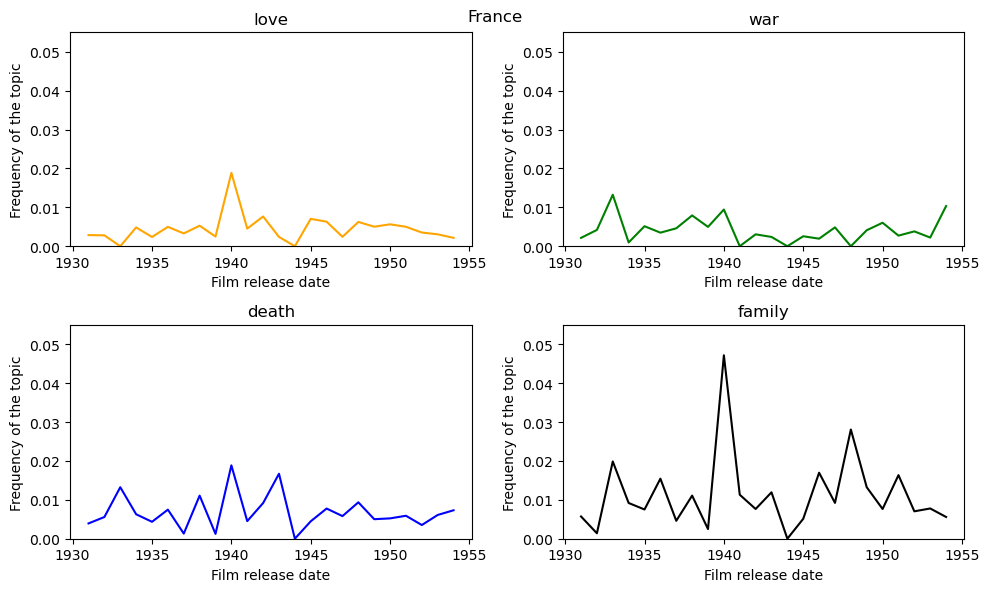

In [49]:
plot_topic_analysis_by_year(df_ww2_french, begin+1, end, categories, "test2", "France")

We can't see any form of pattern here ?... Except the 1945 year that is very positive (victory for France)

---

# Italy

We then run the analysis over all **italian** movies during this period **(1930 to 1955)**. 

In [50]:
# get all the italian movies
df_ww2_italy = get_country_movies(df_ww2, 'Italy')

# calculate sentiment and add it nicely to the df
df_ww2_italy = sentiment_df(df_ww2_italy)

In [51]:
print("There are", len(df_ww2_italy), "movies made in Italy bewteen", begin, "and", end)

There are 241 movies made in Italy bewteen 1930 and 1955


In [52]:
print("The 40 most common words in Italian movies are : ")
print(most_common_sum(df_ww2_italy, 40))

The 40 most common words in Italian movies are : 
[('young', 127), ('find', 122), ('love', 117), (' ', 112), ('man', 107), ('leave', 93), ('take', 92), ('return', 83), ('film', 83), ('go', 81), ('woman', 80), ('son', 79), ('girl', 78), ('try', 78), ('wife', 72), ('family', 71), ('life', 70), ('kill', 69), ('|', 68), ('tell', 68), ('war', 67), ('end', 67), ('friend', 66), ('money', 66), ('antonio', 65), ('fall', 63), ('home', 63), ('time', 62), ('daughter', 62), ('father', 61), ('meet', 61), ('day', 61), ('work', 59), ('marry', 59), ('live', 57), ('police', 57), ('decide', 57), ('house', 57), ('away', 57), ('town', 56)]


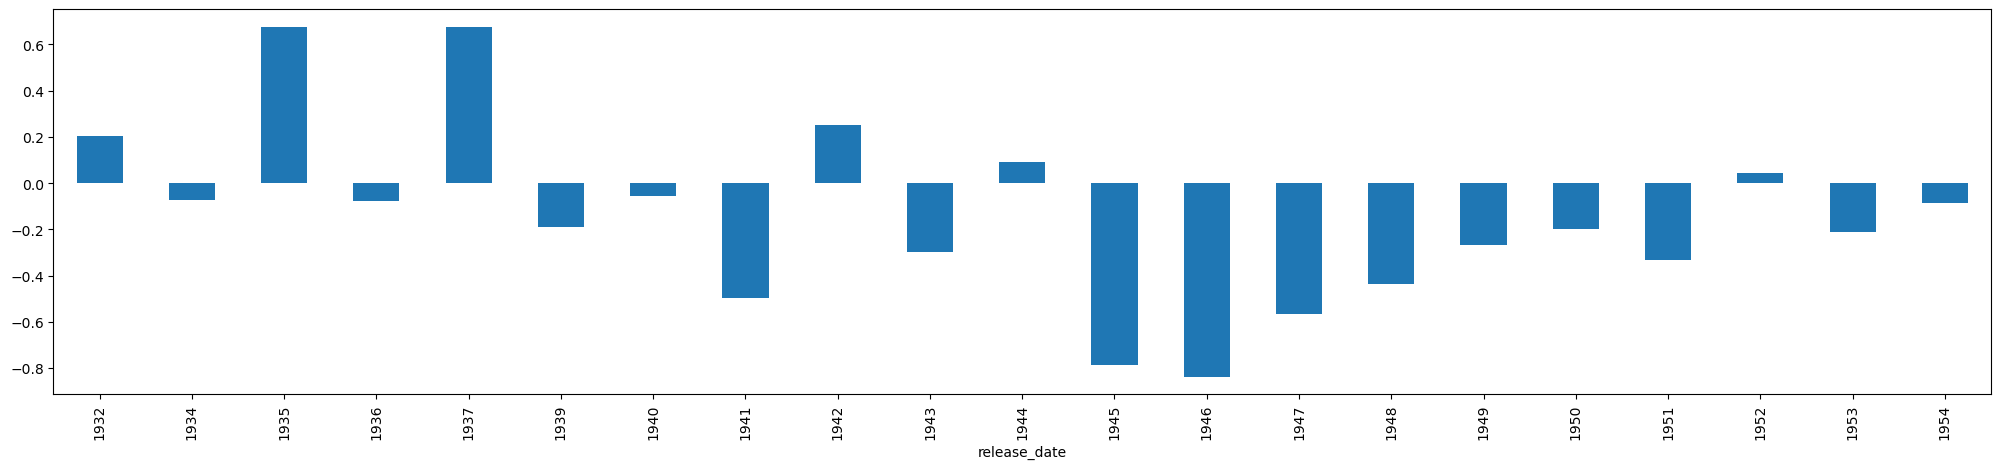

In [53]:
plot_sentiment_country_span(df_ww2_italy, 'compound', year=True)

Seeing the compound value of all the movies at this period we can clearly see that the post war (1945-1949) overall sentiment is negative.

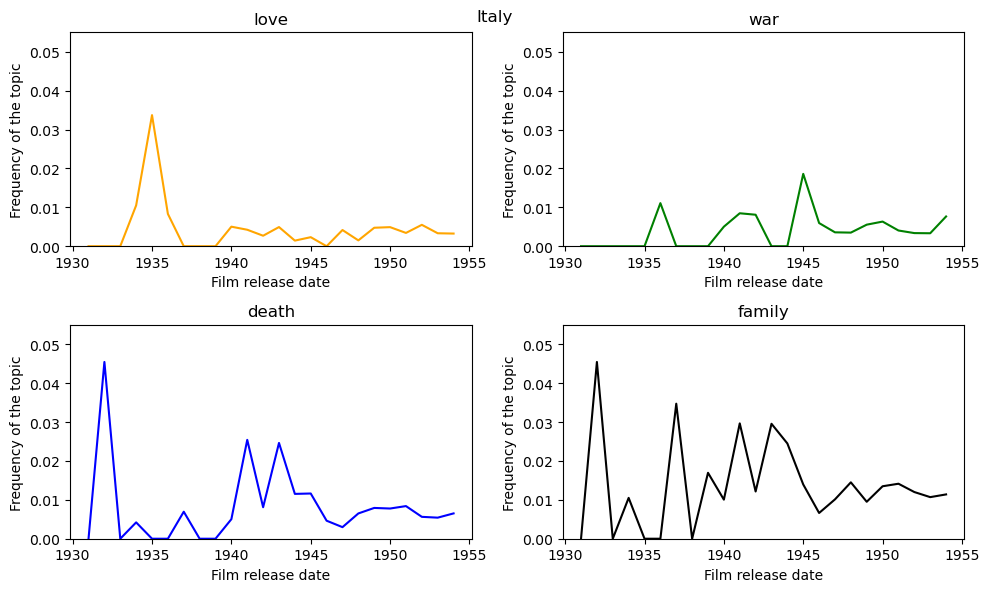

In [54]:
plot_topic_analysis_by_year(df_ww2_italy, begin+1, end, categories, "test3", "Italy")

The peaks in love and death topics in the pre-war period are most likely over representation due to the small number of films. Death is a more recurrent topic in italian films during the war than it was in german films. On the other hand, war is a less recurrent topic in post-war italian films than it was for post-war german films.

___

# United Kingdom

We then run this analysis over all **english** movies during this period **(1930 to 1955)**.

In [55]:
# get all the UK movies
df_ww2_UK = get_country_movies(df_ww2, 'United Kingdom')

# calculate sentiment and add it nicely to the df
df_ww2_UK = sentiment_df(df_ww2_UK)

In [56]:
print("There are", len(df_ww2_UK), "movies made in UK bewteen", begin, "and", end)

There are 1083 movies made in UK bewteen 1930 and 1955


In [57]:
print("The 40 most common words in English movies are : ")
print(most_common_sum(df_ww2_UK, 40))

The 40 most common words in English movies are : 
[(' ', 894), ('find', 627), ('man', 559), ('leave', 471), ('take', 447), ('tell', 416), ('love', 416), ('return', 370), ('try', 356), ('film', 350), ('go', 347), ('work', 325), ('wife', 310), ('young', 309), ('|', 303), ('war', 301), ('london', 300), ('come', 294), ('fall', 292), ('father', 283), ('police', 281), ('woman', 277), ('home', 274), ('british', 273), ('marry', 271), ('arrive', 262), ('meet', 262), ('time', 262), ('kill', 259), ('life', 253), ('new', 251), ('train', 246), ('friend', 244), ('house', 238), ('run', 238), ('help', 237), ('murder', 233), ('day', 233), ('year', 231), ('away', 230)]


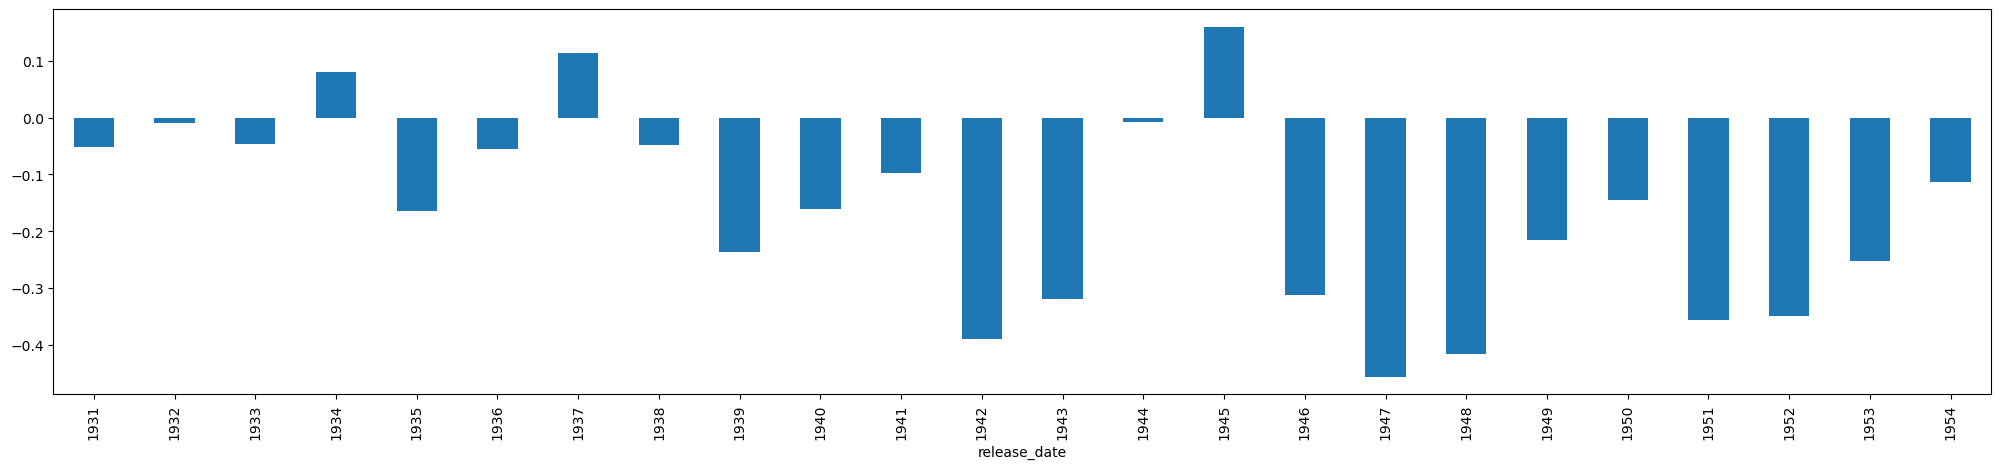

In [58]:
plot_sentiment_country_span(df_ww2_UK, 'compound', year=True)

Seeing the compound value of all the movies at this period we can see that the war (1939-1945) overall sentiment is negative, execpt the last year (vicory for UK) where it is positive. 
Also the post war period is tainted with negativity  (1946 - 1951).

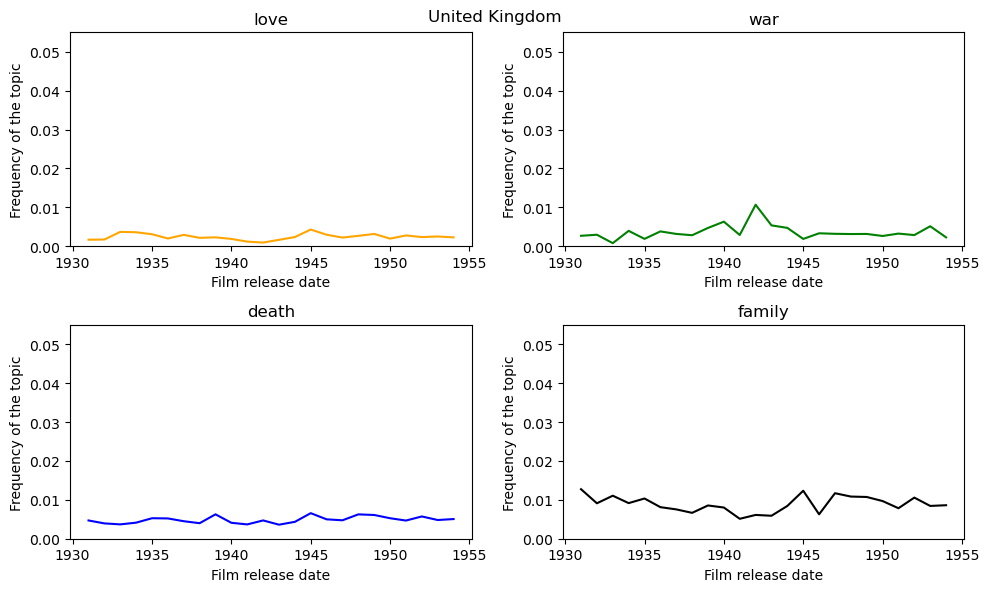

In [59]:
plot_topic_analysis_by_year(df_ww2_UK, begin+1, end, categories, "test4", "United Kingdom")

The war topic gains in popularity during the war for the english films.
___

# Soviet Union

We then run this analysis over all **soviet** movies during this period **(1930 to 1955)**.

In [60]:
# get all the Russian movies
df_ww2_SovietUnion = df_ww2[df_ww2.coutries.apply(lambda x : "Soviet Union" in x or "Russia" in x)]


# calculate sentiment and add it nicely to the df
df_ww2_SovietUnion = sentiment_df(df_ww2_SovietUnion)

In [61]:
print("There are", len(df_ww2_SovietUnion), "movies made in the Soviet Union bewteen", begin, "and", end)

There are 55 movies made in the Soviet Union bewteen 1930 and 1955


In [62]:
print("The 40 most common words in Soviet movies are : ")
print(most_common_sum(df_ww2_SovietUnion, 40))

The 40 most common words in Soviet movies are : 
[('ivan', 51), ('|', 41), ('film', 39), ('work', 34), ('soviet', 34), ('moscow', 32), ('come', 28), ('stalin', 28), (' ', 27), ('people', 27), ('war', 25), ('young', 23), ('send', 21), ('worker', 21), ('army', 21), ('leave', 21), ('force', 20), ('yussuf', 20), ('return', 19), ('order', 19), ('friend', 19), ('red', 19), ('soldier', 18), ('russian', 18), ('german', 18), ('man', 18), ('son', 18), ('father', 18), ('find', 17), ('go', 17), ('begin', 16), ('city', 16), ('see', 16), ('village', 16), ('island', 16), ('alyosha', 16), ('mariya', 16), ('lead', 15), ('take', 15), ('help', 15)]


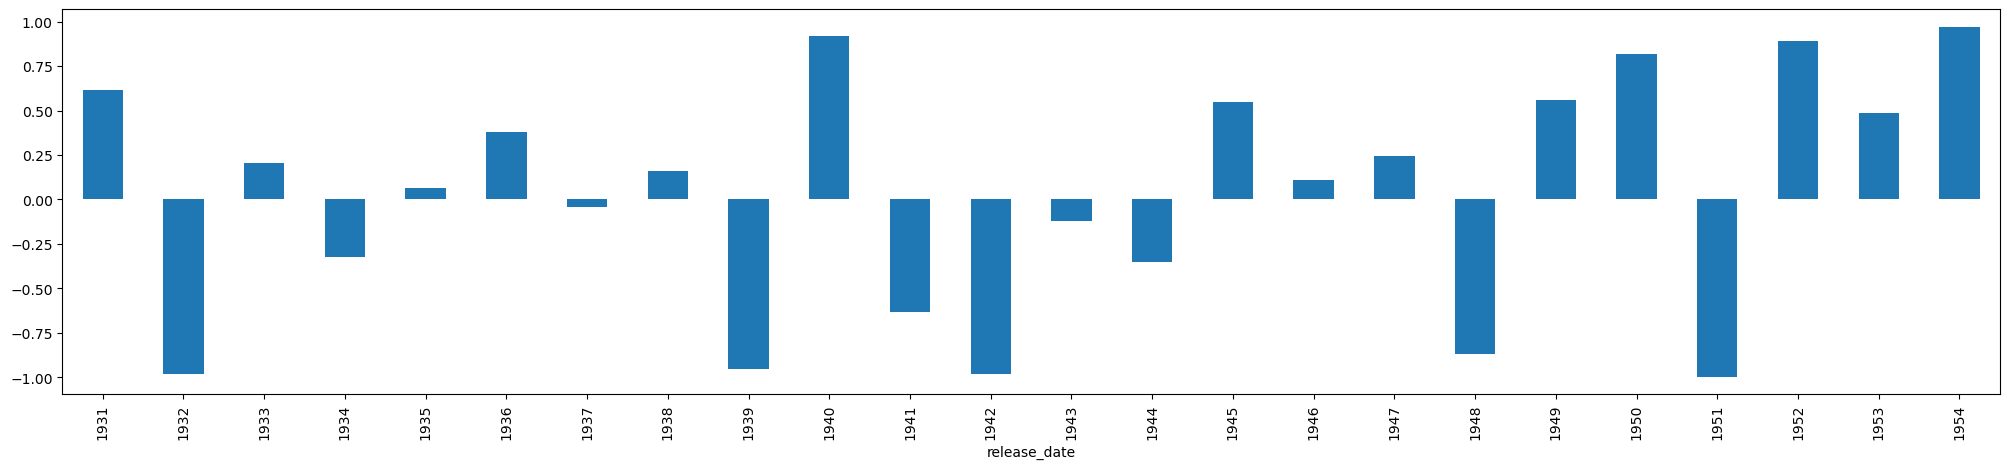

In [63]:
plot_sentiment_country_span(df_ww2_SovietUnion, 'compound', year=True)

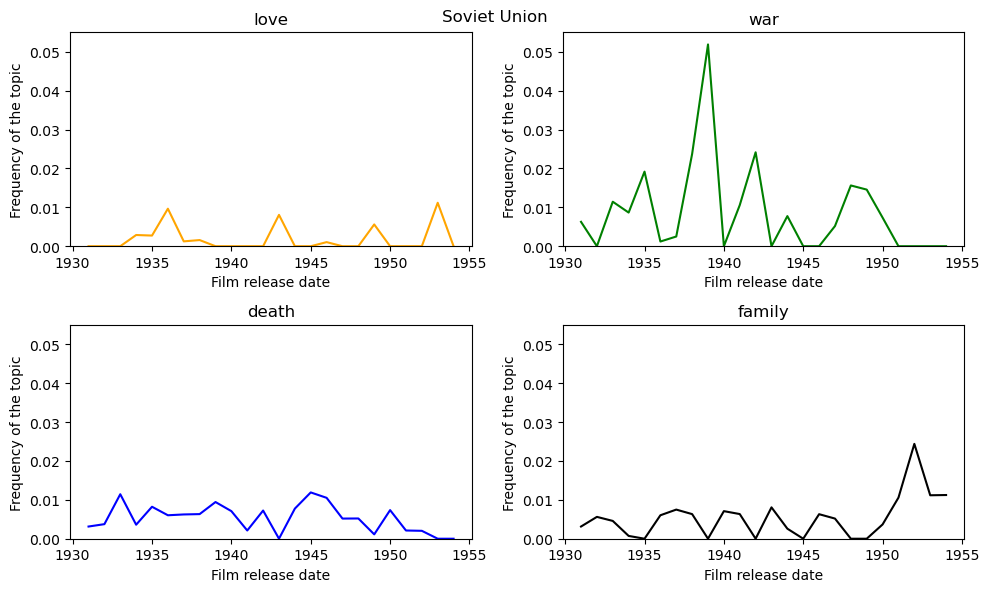

In [64]:
plot_topic_analysis_by_year(df_ww2_SovietUnion, begin+1, end, categories, "test5", "Soviet Union")

We can see that war is a particularly prevalent topic in Soviet movies around the beginning of WW2, and that the tipic of family becomes a lot more popular after the war.

___

# United States of America

We then run this over all **American** movie during this period **(1930 to 1955)**.

In [65]:
# get all the USA movies
df_ww2_USA = get_country_movies(df_ww2, 'United States of America')

# calculate sentiment and add it nicely to the df
df_ww2_USA = sentiment_df(df_ww2_USA)

In [66]:
print("There are", len(df_ww2_USA), "movies made in USA bewteen", begin, "and", end)

There are 5592 movies made in USA bewteen 1930 and 1955


In [67]:
print("The 40 most common words in American movies are : ")
print(most_common_sum(df_ww2_USA, 40))

The 40 most common words in American movies are : 
[(' ', 7503), ('find', 4122), ('man', 4009), ('tell', 3596), ('leave', 3435), ('try', 3053), ('take', 2761), ('go', 2658), ('love', 2585), ('new', 2559), ('return', 2544), ('kill', 2402), ('come', 2209), ('tom', 2064), ('|', 2008), ('father', 1950), ('time', 1947), ('work', 1891), ('home', 1879), ('friend', 1860), ('marry', 1825), ('get', 1819), ('run', 1810), ('fall', 1805), ('meet', 1779), ('see', 1772), ('help', 1767), ('away', 1687), ('decide', 1670), ('money', 1659), ('arrive', 1647), ('end', 1642), ('give', 1623), ('turn', 1617), ('woman', 1600), ('day', 1588), ('life', 1587), ('later', 1560), ('want', 1556), ('police', 1555)]


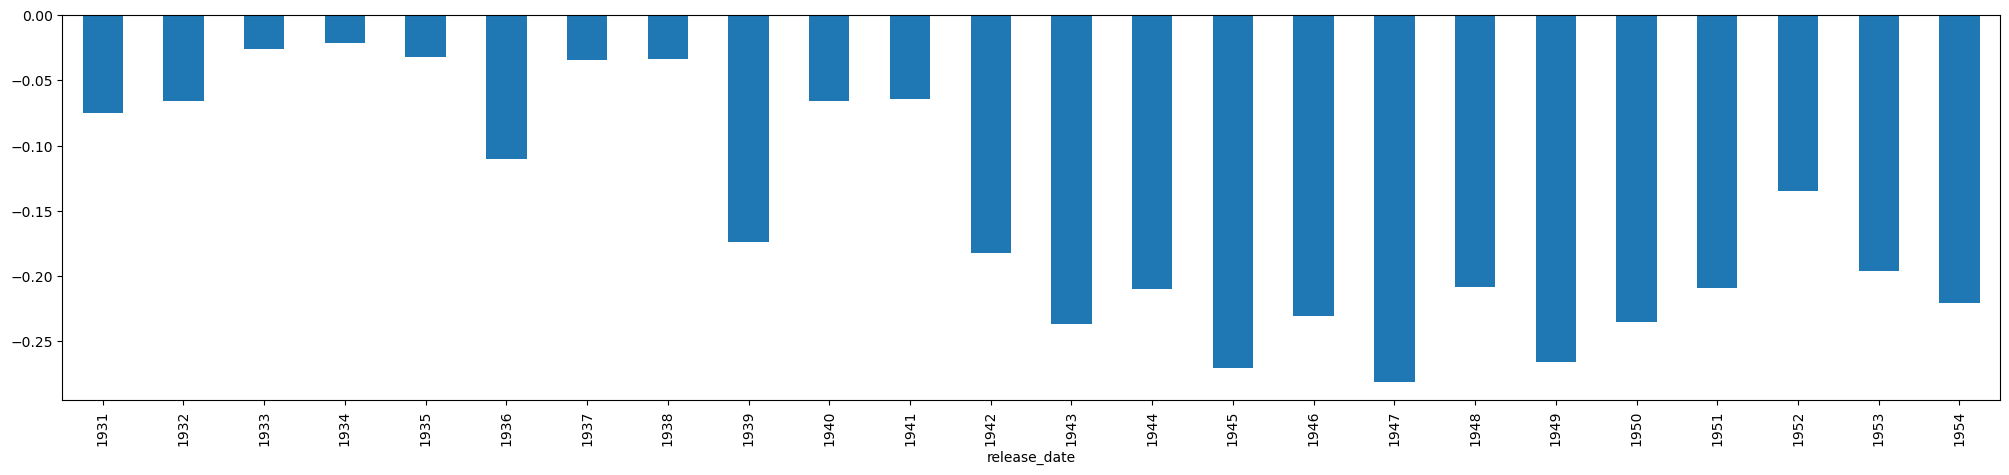

In [68]:
plot_sentiment_country_span(df_ww2_USA, 'compound', year=True)

We can see from the compound values that sentiment is always negative. However, it becomes a lot more negative after the USA's involvment in the war (1941).

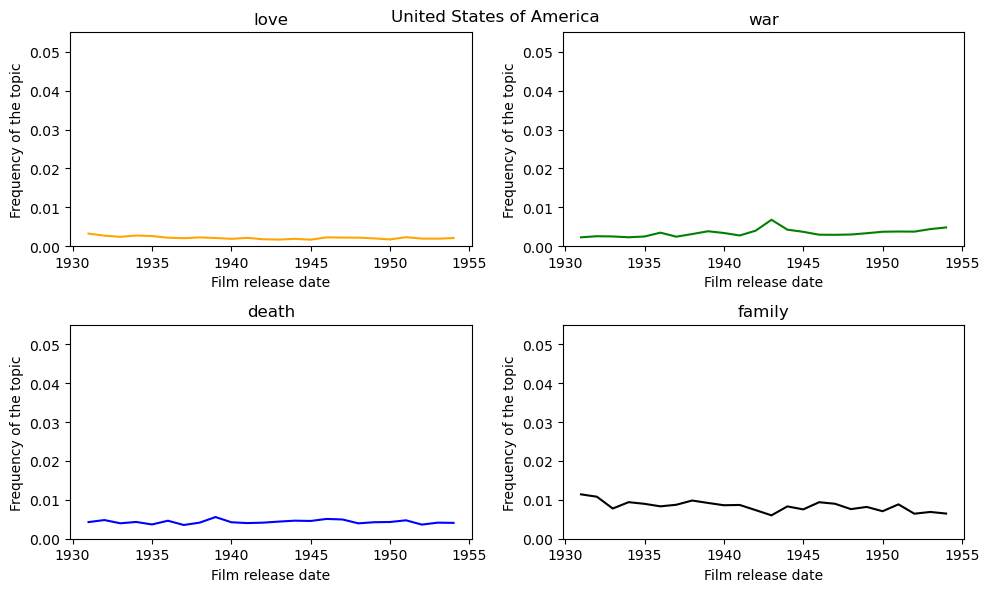

In [69]:
plot_topic_analysis_by_year(df_ww2_USA, begin+1, end, categories, "test6", "United States of America")

The topics are mostly similar to the English topics.

---

# Japan

We then run this analysis over all **japanese** movies during this period **(1930 to 1955)**.

In [70]:
# get all the Japan movies
df_ww2_japan = get_country_movies(df_ww2, 'Japan')

# calculate sentiment and add it nicely to the df
df_ww2_japan = sentiment_df(df_ww2_japan)

In [71]:
print("There are", len(df_ww2_japan), "movies made in Japan bewteen", begin, "and", end)

There are 74 movies made in Japan bewteen 1930 and 1955


In [73]:
print("The 40 most common words in Japanese movies are : ")
print(most_common_sum(df_ww2_japan, 40))

The 40 most common words in Japanese movies are : 
[('father', 102), ('leave', 79), (' ', 76), ('tell', 73), ('find', 73), ('son', 73), ('return', 68), ('work', 66), ('tokyo', 63), ('man', 62), ('home', 62), ('samurai', 54), ('take', 53), ('noriko', 51), ('wife', 51), ('young', 50), ('family', 50), ('go', 49), ('money', 47), ('husband', 47), ('time', 46), ('ask', 46), ('day', 46), ('daughter', 45), ('try', 45), ('meet', 41), ('film', 41), ('mother', 40), ('visit', 39), ('kihachi', 38), ('miyoharu', 38), ('year', 37), ('decide', 37), ('woman', 36), ('run', 36), ('kill', 36), ('end', 35), ('|', 35), ('die', 35), ('old', 34)]


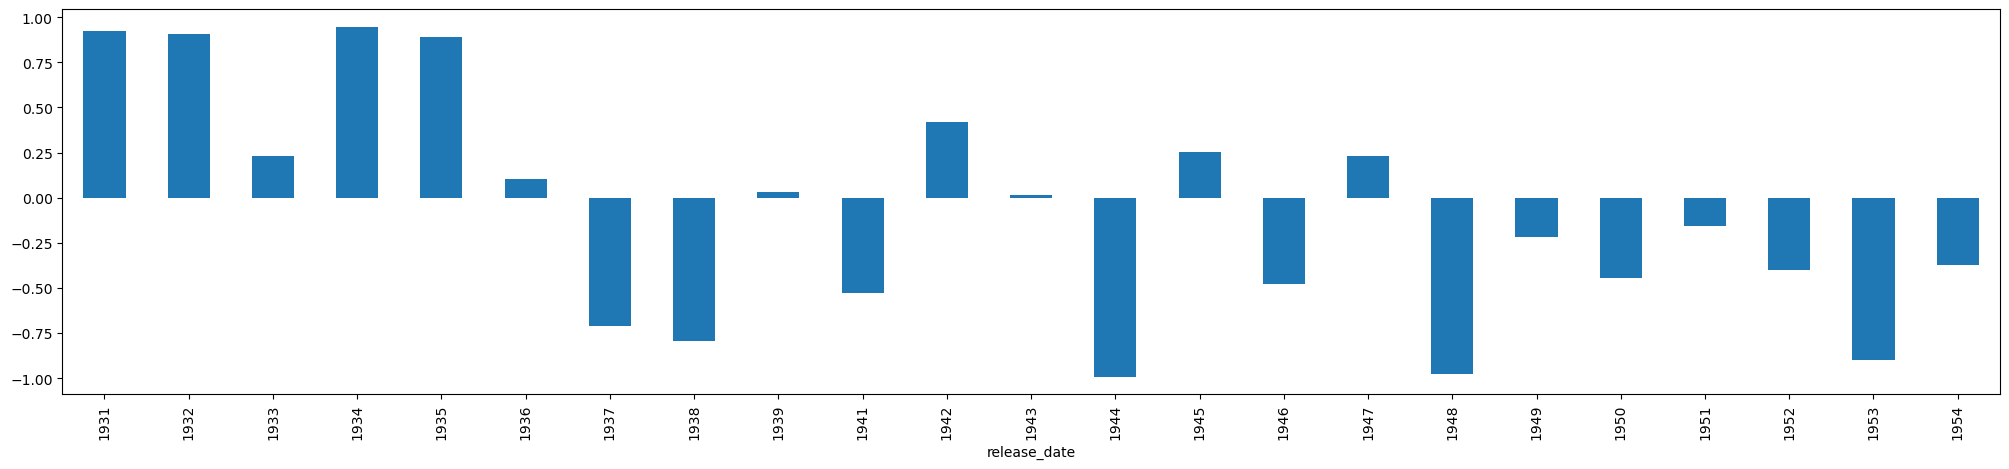

In [74]:
plot_sentiment_country_span(df_ww2_japan, 'compound', year=True)

Pre war (before 1939)  is pretty positive. The rest of the period is moslty negative.

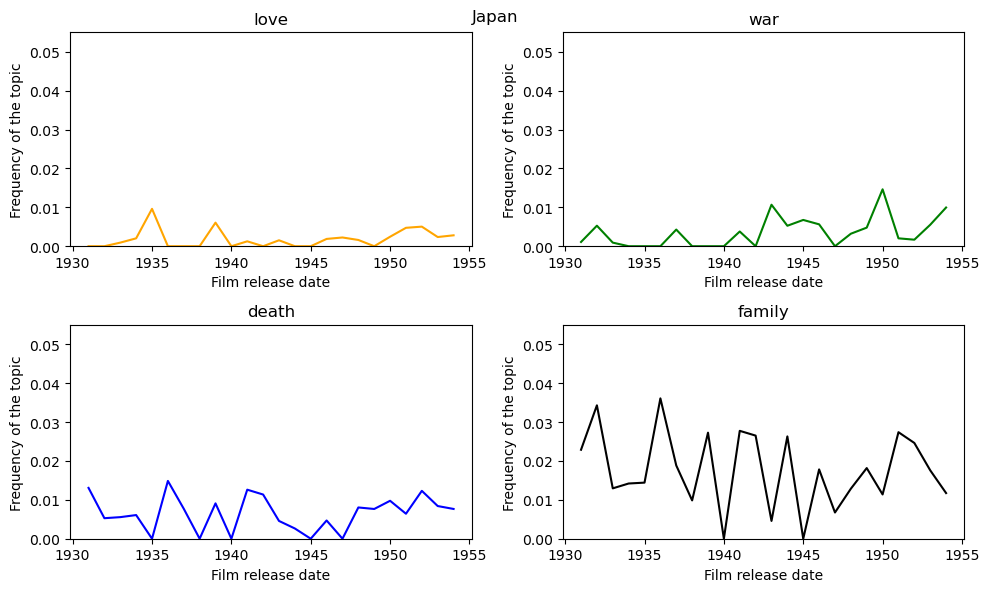

In [75]:
plot_topic_analysis_by_year(df_ww2_japan, begin+1, end, categories, "test7", "Japan")

Like in Germany, family is the most recurring topic, and love is barely discussed. Interestingly, death is a more prevalent topic than war.

___

## Community detection

Finally, we do community detection on films made during World War II in the main involved countries.

In [76]:
df = summary_df
df = df[df.summary !='']
before_war = (datetime.date(1929, 9, 1),datetime.date(1939, 9, 1))
during_war= (datetime.date(1939, 9, 1), datetime.date(1945, 9, 2))
after_war = (datetime.date(1945, 9, 2), datetime.date(1955, 9, 2))
WWII_countries = ['United States of America', 'Germany', 'France', 'United Kingdom','Soviet Union','Japan','Italy']

In [96]:
import community

In [ ]:
import warnings
warnings.filterwarnings("ignore")

#Here you can check the different topics for every country before during, after the war
display_topics = topic_detetction_country(df, WWII_countries[0], before_war)

(2275, 11)


In [ ]:
#Here you can display any of the topics of any cluster
pyLDAvis.display(display_topics[0])

|   Country  |  01.09.1929- 01.09.1939 | 01.09.1939- 02.09.1945 | 02.09.1945- 02.09.1955|
|:-:    |:-:    |:-:    |:-:    |
|   USA   |   (Investigation,crime)(love)(unclear)   |   (cartoons)(war)(love) |  (love)(cartoons)(fugitives,escape) |
|   GERMANY   |   (Hitler,nationalism,nazi)(investigation)  |   (prussian war)(Artistocracy) |  (WWII)(unclear) |
|   FRANCE   |   (WWI)(crime)(unclear)   |   (Marriage, love)(Marriage, love) |  (WWII)(unclear) |
|   ITALY   |   (love,war)(unclear)   |   (soldiers,religion)(Family,struggle) |   (WWII)(political conflict)(love)(unclear) |
|   UK   |   (fugitives, escaping, war)(love,money)(unclear)(unclear)   |   (Nazis, war)(Aviation)(Dramas)(unclear)(unclear) |   (WWII)(love)(unclear) |
|   USSR   |   (war,revolution)(workers)(WWI, Germany)(workers,communism)   |   (war) |   (WWII)(unclear) |
|   JAPAN   |   (tradition, family)(unclear)   |   (tradition, history)(industry, social status) |   (science fiction)(relationships)(unclear) |


## Case study : Vietnam War

The Vietnam War started on November 1st, 1955 and ended on April 30th, 1975. It involved many countries, but was mainly a conflict between the USSR and China and the USA on Vietnamese soil. In popular culture, it is known for a rise of anti-war sentiment.

### War films

First, let's look at the percentage of war movies made throughout the years around the Vietnam War, in the world and in the USA.

In [79]:
print("There are", len(get_country_movies(df_relevant, "Vietnam")), "movies made in Vietnam")

There are 28 movies made in Vietnam


From exploring the above dataset, we can see that there are only very few Vietnamese movies made before the 2000s, and only 28 overall. Since this is so little compared to movies in the USSR and in the USA, we decided that we do not have enough data to be able to compare themm with Vietnamese movies. We therefore do not consider Vietnamese movies in this analysis.

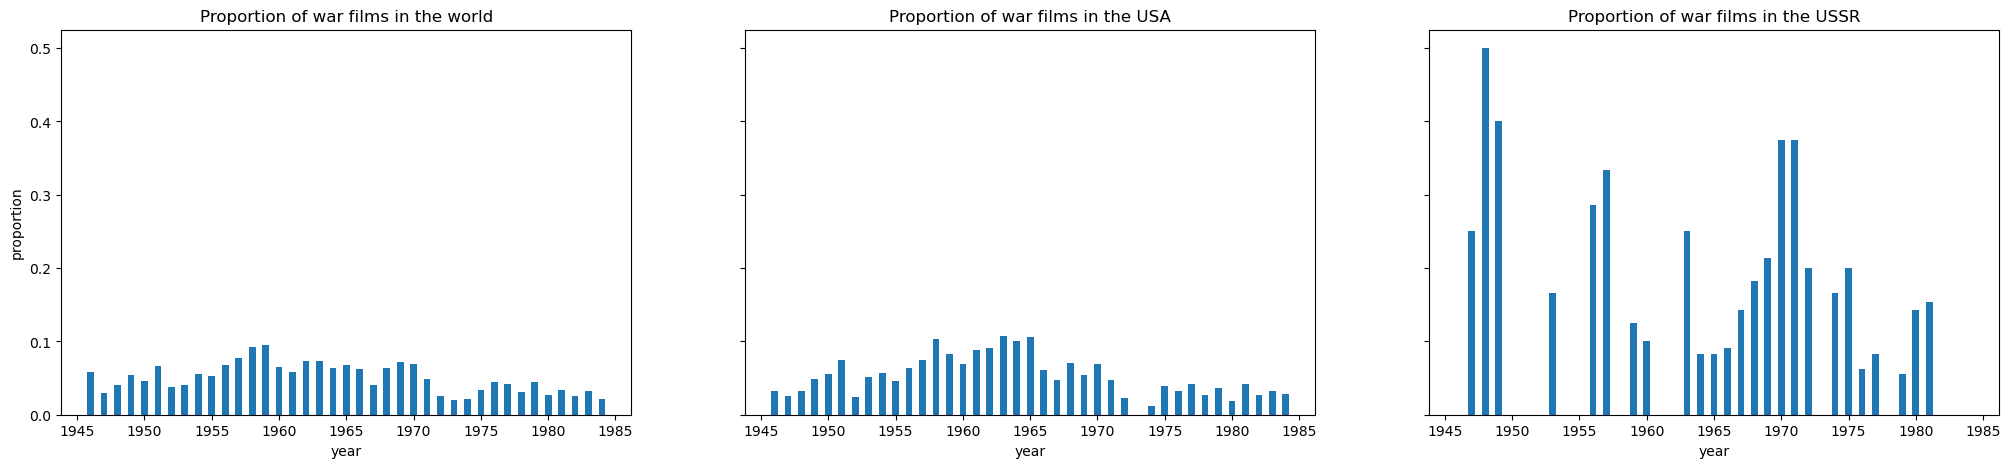

In [80]:
fims_USSR_and_Russia = df_relevant[df_relevant.coutries.apply(lambda x : "Russia" in x or "Soviet Union" in x)]

films_USA = create_history_span(get_country_movies(df_relevant, "United States of America"), 1945, 1985)
films_USSR = create_history_span(fims_USSR_and_Russia, 1945, 1985)

war_films = proportion_of_movie_genre(create_history_span(df, 1945, 1985), "War film")
war_films_USA = proportion_of_movie_genre(films_USA, "War film")
war_films_USSR = proportion_of_movie_genre(films_USSR, "War film")

comparing_three_plots("Proportion of war films in the world", "Proportion of war films in the USA", "Proportion of war films in the USSR", "proportion", "year", war_films, war_films_USA, war_films_USSR)

In [81]:
print("There are",len(films_USA),"films made in the USA between 1945 and 1985")
print("There are",len(films_USSR),"films made in the Soviet Union between 1945 and 1985")
print("The median of movies made by year in the Soviet Union between 1945 and 1985 is", films_USSR.groupby(films_USSR.release_date.dt.year)['wiki_id'].count().median())

There are 8510 films made in the USA between 1945 and 1985
There are 341 films made in the Soviet Union between 1945 and 1985
The median of movies made by year in the Soviet Union between 1945 and 1985 is 9.0


We can see that the proportion of war films in the USSR is much higher than in the USA. However, we also need to consider that there are a lot less films produced there in our dataset. Since our dataset has mostly American movies, it makes sense that the shape of the graph of war films in the USA is similar to the one for war films in the world.

___

### Anti-war films

Now let us look at the proportion of anti-war films.

In [82]:
print("There is", len(fims_USSR_and_Russia[fims_USSR_and_Russia.genres.apply(lambda x :"Anti-war" in x)]), "anti-war films made in the USSR")

There is 1 anti-war films made in the USSR


We continue our analysis only on American films since there is only one Soviet anti-war film.

In [83]:
anti_war_films_proportion = proportion_of_movie_genre(create_history_span(get_other_country_movies(df_relevant, "United States of America"), 1920, 2020), "Anti-war")
anti_war_films_USA_proportion = proportion_of_movie_genre(create_history_span(get_country_movies(df_relevant, "United States of America"), 1920, 2020), "Anti-war")

The p-value for the difference in number of non-American war films during the Vietnam War and before and after is : 0.26973609213241206
The p-value for the difference in number of American war films during the Vietnam War and before and after is : 3.865388150710535e-05


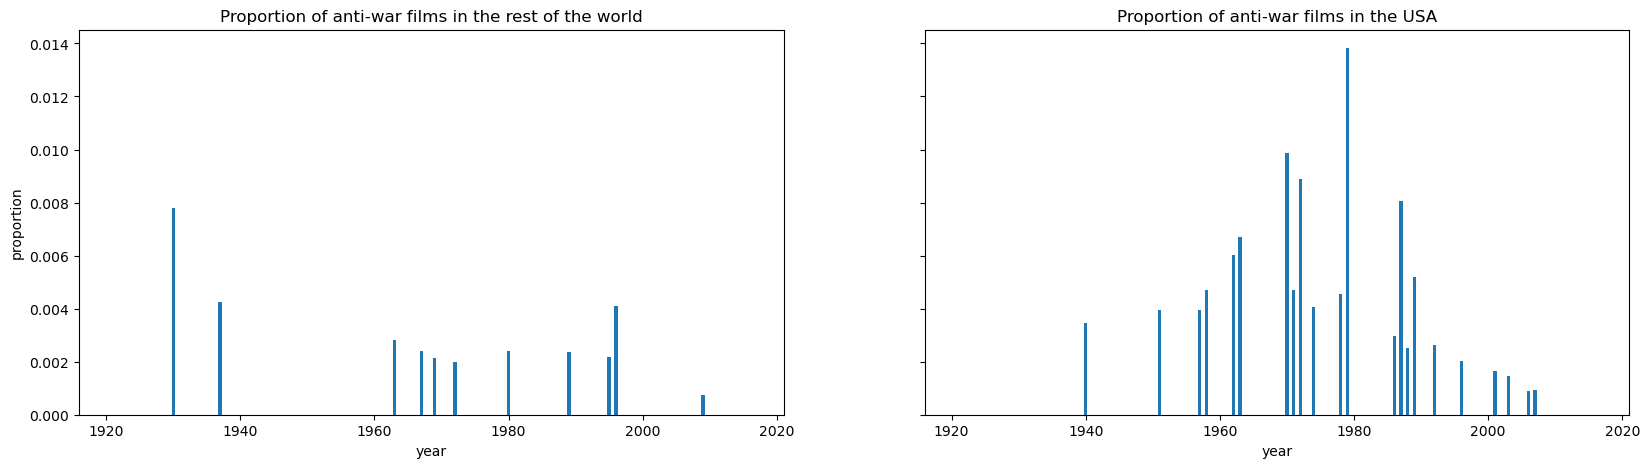

In [84]:
anti_war_films_ww_not_war = proportion_of_movie_genre(create_inverse_history_span(get_other_country_movies(df_relevant, "United States of America"), 1955, 1975), "Anti-war")
anti_war_films_ww_war = proportion_of_movie_genre(create_history_span(get_other_country_movies(df_relevant, "United States of America"), 1955, 1975), "Anti-war")
anti_war_films_USA_not_war = proportion_of_movie_genre(create_inverse_history_span(get_country_movies(df_relevant, "United States of America"), 1955, 1975), "Anti-war film")
anti_war_films_USA_war = proportion_of_movie_genre(create_history_span(get_country_movies(df_relevant, "United States of America"), 1955, 1975), "Anti-war film")

_, p_value_ww = scipy.stats.ttest_ind(anti_war_films_ww_not_war, anti_war_films_ww_war)
_, p_value_USA = scipy.stats.ttest_ind(anti_war_films_USA_not_war, anti_war_films_USA_war)
print("The p-value for the difference in number of non-American war films during the Vietnam War and before and after is :", p_value_ww)
print("The p-value for the difference in number of American war films during the Vietnam War and before and after is :", p_value_USA)


comparing_two_plots("Proportion of anti-war films in the rest of the world", "Proportion of anti-war films in the USA", "proportion", "year", anti_war_films_proportion, anti_war_films_USA_proportion)

From the p-values, we can see that the difference in number of anti-war films during and before and after the Vietnam War in the USA is statistically significant.

### Topic analysis

In [85]:
anti_war_movies_viet_war = create_history_span(get_country_movies(summary_df[summary_df.genres.apply(lambda x :"Anti-war" in x)], "United States of America"), 1945, 1985)
topics = topic_analysis(anti_war_movies_viet_war, [])
sorted_topics = sorted(topics.items(), key=operator.itemgetter(1),reverse=True)
print("The ten most prelavent topics in American anti-war films are :")
sorted_topics[:10]

The ten most prelavent topics in American anti-war films are :


[('military', 0.016474464579901153),
 ('war', 0.015032948929159802),
 ('weapon', 0.013797364085667216),
 ('fight', 0.010090609555189456),
 ('kill', 0.007619439868204283),
 ('negative_emotion', 0.00700164744645799),
 ('leader', 0.006589785831960461),
 ('crime', 0.005766062602965404),
 ('prison', 0.0055601317957166396),
 ('death', 0.0055601317957166396)]

In [86]:
war_movies_viet_war = create_history_span(get_country_movies(summary_df[summary_df.genres.apply(lambda x :"War film" in x)], "United States of America"), 1945, 1985)
topics = topic_analysis(war_movies_viet_war, [])
sorted_topics = sorted(topics.items(), key=operator.itemgetter(1),reverse=True)
print("The ten most prelavent topics in American war films are :")
sorted_topics[:10]

The ten most prelavent topics in American war films are :


[('military', 0.012595477421389684),
 ('war', 0.012348641717976496),
 ('fight', 0.009976276346283066),
 ('leader', 0.007905599056539089),
 ('weapon', 0.007357075271176446),
 ('negative_emotion', 0.006979965168739629),
 ('kill', 0.005697790820454452),
 ('family', 0.005601799158015989),
 ('children', 0.005306967623383569),
 ('death', 0.005121840845823677)]

### Word analysis

The p-value for the difference in mentions of Vietnam in American films during the Vietnam War and before and after is : 0.303467274845908


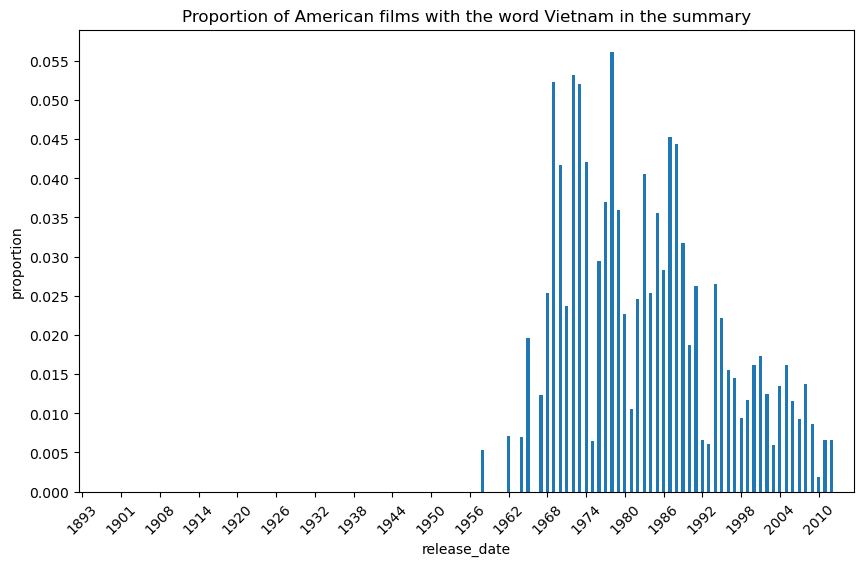

In [87]:
prop = plot_proportion(proportion_of_list_in_summary(get_country_movies(summary_df, "United States of America"), ["vietnam"]), "Proportion of American films with the word Vietnam in the summary")
prop_war = proportion_of_list_in_summary(create_history_span(get_country_movies(summary_df, "United States of America"), 1955, 1980), ["vietnam"])
prop_after_war = proportion_of_list_in_summary(create_history_span(get_country_movies(summary_df, "United States of America"), 1980, 2020), ["vietnam"])

_, p_value = scipy.stats.ttest_ind(prop_war, prop_after_war)
print("The p-value for the difference in mentions of Vietnam in American films during the Vietnam War and before and after is :", p_value)

As we can see, American movies did not discuss Vietnam at all before the war. We can also see that the difference between the proportion of these movies made during and after the war is not statistically significant, similarly to Germany and World War II. However, visually, we can see that the proportion of movies mentioning Vietnam goes down a lot after the end of the war.

___

In [88]:
movies_vietnam = get_country_movies(summary_df[summary_df.summary.apply(lambda x :"vietnam" in x.lower())], "United States of America")
topics = topic_analysis(movies_vietnam, [])
sorted_topics = sorted(topics.items(), key=operator.itemgetter(1),reverse=True)
print("The ten most prelavent topics in American films that mention Vietnam are :")
sorted_topics[:10]

The ten most prelavent topics in American films that mention Vietnam are :


[('negative_emotion', 0.0075360372587396605),
 ('war', 0.007486035115790677),
 ('family', 0.006978870523022415),
 ('fight', 0.006821720930897038),
 ('children', 0.006578853379430547),
 ('crime', 0.00642170378730517),
 ('military', 0.006414560624026744),
 ('death', 0.00577881909224681),
 ('home', 0.00536451562209809),
 ('traveling', 0.005350229295541237)]

From these topics, we can see that war and violence are major topics in American movies that somehow include Vietnam. Finally, we count the percentage of American movies that include the words "vietnam" and "war".

In [89]:
movies_vietnam_war = get_country_movies(summary_df[summary_df.summary.apply(lambda x :"vietnam war" in x.lower())], "United States of America")
movies_vietnam_and_war = get_country_movies(summary_df[summary_df.summary.apply(lambda x :"vietnam" in x.lower() and "war" in x.lower())], "United States of America")
print("Proportion of American movies that include 'Vietnam war' if they include 'vietnam' :", len(movies_vietnam_war)/len(movies_vietnam))
print("Proportion of American movies that also include 'war' if they include 'vietnam' :", len(movies_vietnam_and_war)/len(movies_vietnam))

Proportion of American movies that include 'Vietnam war' if they include 'vietnam' : 0.4473684210526316
Proportion of American movies that also include 'war' if they include 'vietnam' : 0.7730263157894737


We compare this with the words "nazi" and "war" in American movies whose summaries mention Germany.

In [90]:
movies_germany= get_country_movies(summary_df[summary_df.summary.apply(lambda x :"germany" in x.lower())], "United States of America")
movies_war_and_nazi = get_country_movies(summary_df[summary_df.summary.apply(lambda x :("war" in x.lower() and "germany" in x.lower()) or ("nazi" in x.lower() and "germany" in x.lower()))], "United States of America")
print("Proportion of American movies that also include 'war' or 'nazi' if they include 'Germany' :", len(movies_war_and_nazi)/len(movies_germany))

Proportion of American movies that also include 'war' or 'nazi' if they include 'Germany' : 0.8439716312056738


In [91]:
movies_usa = get_country_movies(summary_df[summary_df.summary.apply(lambda x :"america" in x.lower() or "usa" in x.lower() or "united states" in x.lower())], "Germany")
movies_usa_and_war = get_country_movies(summary_df[summary_df.summary.apply(lambda x :("war" in x.lower() and "america" in x.lower()) or ("war" in x.lower() and "usa" in x.lower()) or ("war" in x.lower() and "united states" in x.lower()))], "Germany")
print("Proportion of American movies that also include 'war' if they mention the USA :",len(movies_usa_and_war)/len(movies_usa))

movies_usa_vietnam = get_country_movies(summary_df[summary_df.summary.apply(lambda x :"america" in x.lower() or "usa" in x.lower() or "united states" in x.lower())], "Vietnam")
movies_usa_and_war_vietnam = get_country_movies(summary_df[summary_df.summary.apply(lambda x :("war" in x.lower() and "america" in x.lower()) or ("war" in x.lower() and "usa" in x.lower()) or ("war" in x.lower() and "united states" in x.lower()))], "Vietnam")
print("Proportion of Vietnamese movies that also include 'war' if they mention the USA : :",len(movies_usa_and_war_vietnam)/len(movies_usa_vietnam))

Proportion of American movies that also include 'war' if they mention the USA : 0.6222222222222222
Proportion of Vietnamese movies that also include 'war' if they mention the USA : : 0.25


We can see that American movies often treat Vietnam and Germany in relation to the wars that happened there.